<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L6_IsoProbabilisticTransformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Iso-probabilistic transformation
 $$T: X  → U  \text{  where  }  U\sim N(0,I)=\Phi$$


* Moment-based
* Rosembatt
* Nataf



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, multivariate_normal
import scipy.stats as stats
from scipy.linalg import cholesky
from numpy.random import multivariate_normal as mvn_rnd

In [2]:
# =====================================================
# Define the Probabilistic Model
# =====================================================
def DGM(n_samples: int = 5000, n_dim=2):
  """
  A data generating mechanism
    Args:
        n_samples: integer number of samples
        n_dim: number of dimensions of x
    Returns:
        X: the samples
        marginals: the marginal distributions
        corr_matrix: a correlation matrix

  """
  np.random.seed(42)

  # Define marginal distributions (e.g., Lognormal and Weibull)
  marginals = [stats.lognorm(s=0.5, scale=np.exp(0.5)),   # Lognormal
              stats.weibull_min(c=12.0, scale=1.0)]       # Weibul

   # Define correlation matrix
  if n_dim == 2:
      corr_matrix = np.array([[1.0, 0.6], [0.6, 1.0]])
  else:
      corr_matrix = np.eye(n_dim) # no correlation if ndim>2

  # Generate correlated samples from a multivariate gaussian distribution
  Z = mvn_rnd(mean=np.zeros(n_dim),
              cov=corr_matrix,
              size=n_samples)

  U = stats.norm.cdf(Z)  # Transform to uniform space
  X = np.zeros_like(U)   # X contains all zeros same size as U

  for i in range(2):
    X[:, i] = marginals[i].ppf(U[:, i])  # Transform to physical space using inverse CDF

  return X, marginals, corr_matrix


### Apply Iso-Probability Transformations:
- Using 1st and 2nd moments (Moment-based)
- Using marginal distributions (Rosembatt)
- Using marginals & correlation  (Nataf)

In [3]:
# IsoProbTransformations
def Ztransform(X, marginals=None, corr_matrix=None):
    """
    Transforms random variables
           X - > U
           based on marginal moments (mu,std)
    """
    n_samples, n_dim = X.shape
    U = np.zeros_like(X)

    # Step 1: Transform
    for i in range(n_dim):
      U[:,i] = (X[:,i]-np.mean(X[:,i]))/(np.std(X[:,i])) # samples-based

    return U


def rosenblatt_transform(X, marginals, copula=None):
    """
    Rosenblatt transformation for dependent random variables.
    https://openturns.github.io/openturns/latest/theory/numerical_methods/isoprobabilistic_transformation.html#isoprobabilistic-transformation
    Args:
        X: A numpy array of shape (n_samples, n_dim) containing the random variables.
        marginals: A list of scipy.stats distribution objects corresponding to the marginals of X.
        copula: A function representing the copula C(u1, u2, ..., un). If None, independence is assumed.

    Returns:
        U: A numpy array of transformed variables in standard normal space.
    """
    n_samples, n_dim = X.shape
    U = np.zeros_like(X)

    for i in range(n_samples):
        # Initialize the transformed vector for the current sample
        Y = np.zeros(n_dim)

        # Step 1: Transform using marginal and conditional CDFs
        for k in range(n_dim):
            if k == 0:
                # First variable: use marginal CDF
                Y[k] = marginals[k].cdf(X[i, k])
            else:
                # Subsequent variables: use conditional CDF
                if copula is None:
                    # Independence assumption
                    Y[k] = marginals[k].cdf(X[i, k])
                else:
                    # Compute conditional CDF using the copula
                    raise NotImplementedError("Conditional CDF computation requires a copula.")

        # Step 2: Transform to standard normal space using inverse Gaussian CDF
        U[i, :] = norm.ppf(Y)

    return U


def generalized_nataf_transform(X, marginals, corr_matrix, psi=None):
    """
    Generalized Nataf Transformation for correlated random variables with elliptical copulas.
    https://openturns.github.io/openturns/latest/theory/numerical_methods/nataf_transformation.html

    Parameters:
        X (np.ndarray): (n_samples, n_dim) array of correlated random variables.
        marginals (list): List of marginal distribution objects (e.g., scipy.stats distributions).
        corr_matrix (np.ndarray): (n_dim, n_dim) correlation matrix of the elliptical copula.
        psi (callable): Characteristic generator of the elliptical distribution (default: Gaussian).

    Returns:
        U (np.ndarray): (n_samples, n_dim) array of transformed variables in the standard space.
    """
    n_samples, n_dim = X.shape

    # Step 1: Transform to uniform space via marginal CDFs
    W = np.zeros_like(X)
    for i in range(n_dim):
        W[:, i] = marginals[i].cdf(X[:, i])  # T1: X → W (uniform space)

    # Step 2: Transform to elliptical space via inverse CDF of standard elliptical distribution
    if psi is None:
        # Default to Gaussian copula if no characteristic generator is provided
        V = stats.norm.ppf(W)  # T2: W → V (Gaussian space)
    else:
        # For non-Gaussian elliptical copulas, use the inverse CDF of the standard elliptical distribution
        raise NotImplementedError("Custom elliptical copulas require implementing the inverse CDF.")

    # Step 3: Transform to standard space using Cholesky decomposition of the correlation matrix
    Gamma = np.linalg.inv(cholesky(corr_matrix, lower=True))  # T3: V → U (standard space)
    U = V @ Gamma.T

    return U


def inverse_nataf_transform(u, marginals, corr_matrix):
    """
    Invert the Nataf transformation to map U to X.

    Args:
        u: A numpy array of shape (n_samples, n_dim) containing the variables in U-space.
        marginals: A list of scipy.stats distribution objects corresponding to the marginals of X.
        corr_matrix: The correlation matrix of X.

    Returns:
        x: A numpy array of shape (n_samples, n_dim) containing the variables in X-space.
    """
    n_samples, n_dim = u.shape
    x = np.zeros_like(u)

    # Step 1: Generate correlated standard normal variables U
    L = cholesky(corr_matrix, lower=True)  # Cholesky factor of the correlation matrix
    u_correlated = u @ L.T  # Impose correlation structure

    # Step 2: Map U to X using the inverse CDFs
    for i in range(n_dim):
        x[:, i] = marginals[i].ppf(stats.norm.cdf(u_correlated[:, i]))

    return x

In [4]:
# =====================================================
# Examples: Iso-Probability Transformations
# =====================================================

def DGM(n_samples = 5000, n_dim=2):
  """
  A data generating mechanism
  """
  np.random.seed(42)

  # Define marginal distributions (e.g., Lognormal and Weibull)
  marginals = [stats.lognorm(s=0.5, scale=np.exp(0.5)),   # Lognormal
              stats.weibull_min(c=12.0, scale=1.0)]       # Weibul

  # Define correlation matrix (in the elliptical copula space)
  corr_matrix = np.array([[1.0, 0.6], [0.6, 1.0]])

  # Generate correlated samples using a Gaussian copula
  Z = mvn_rnd(mean=np.zeros(len(corr_matrix)), cov=corr_matrix, size=n_samples)
  U = stats.norm.cdf(Z)  # Transform to uniform space
  X = np.zeros_like(U)
  for i in range(2):
    X[:, i] = marginals[i].ppf(U[:, i])  # Transform to physical space using inverse CDF

  return X, marginals, corr_matrix



## Test Transformations

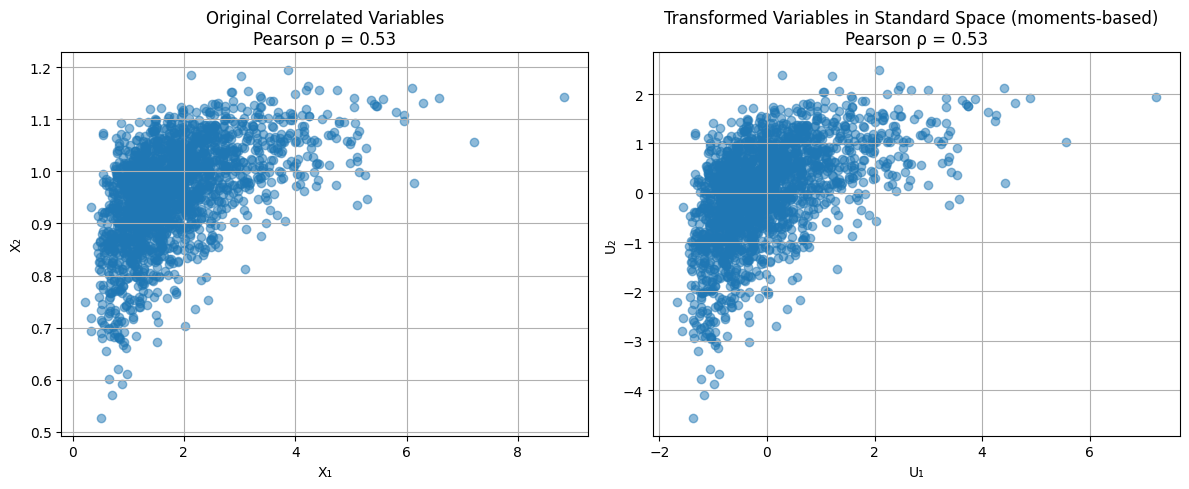

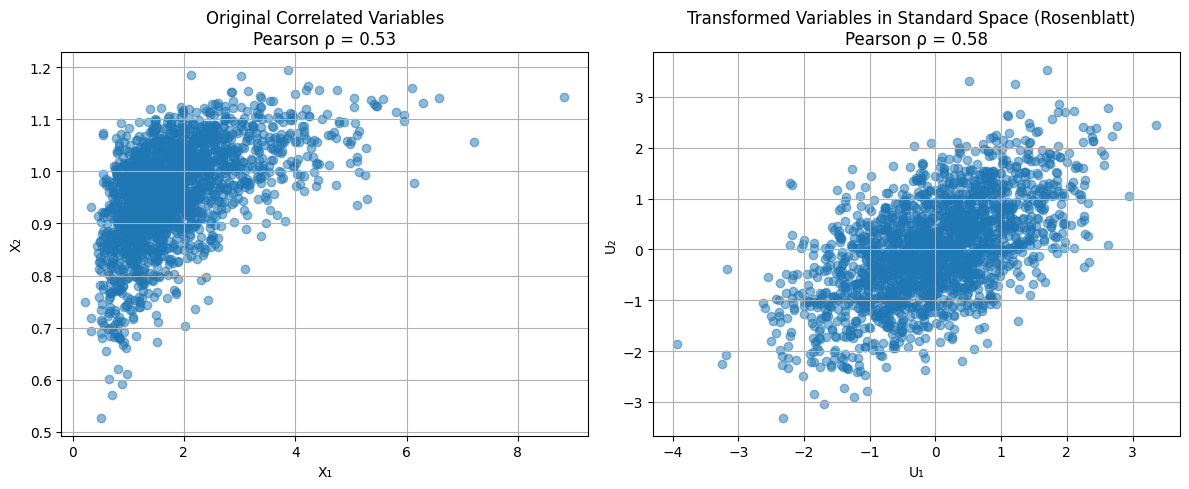

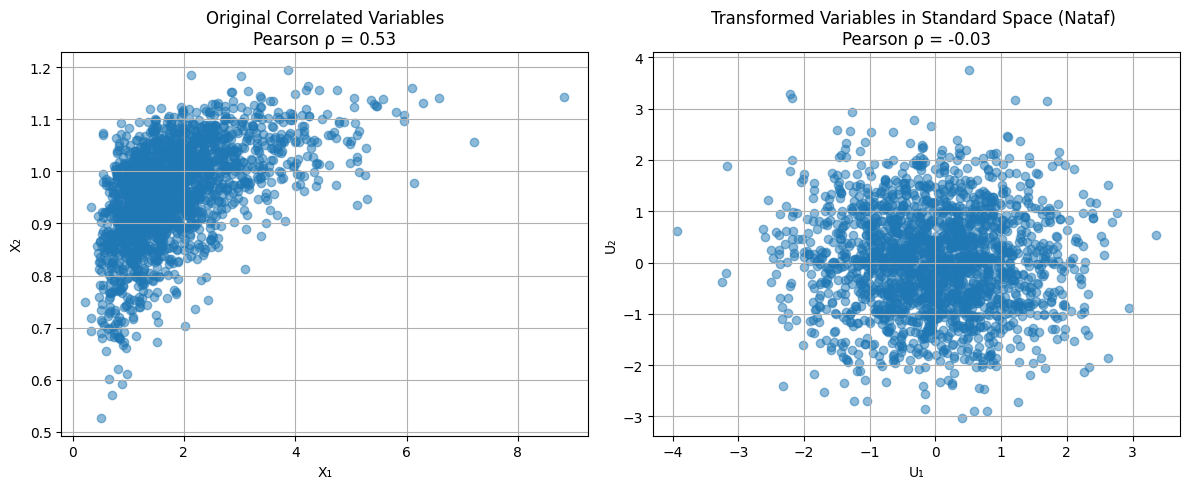

In [5]:
X, marginals, corr_matrix =  DGM(2000)

# =====================================================
# 1. Apply First Transformation
# =====================================================

U_transformed = Ztransform(X)

# =====================================================
# Visualize Results
# =====================================================

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original correlated variables
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.5)
ax[0].set_title(f"Original Correlated Variables\nPearson ρ = {np.corrcoef(X.T)[0,1]:.2f}")
ax[0].set_xlabel("X₁")
ax[0].set_ylabel("X₂")
ax[0].grid()
# Transformed variables in standard space
ax[1].scatter(U_transformed[:, 0], U_transformed[:, 1], alpha=0.5)
ax[1].set_title(f"Transformed Variables in Standard Space (moments-based)  \nPearson ρ = {np.corrcoef(U_transformed.T)[0,1]:.2f}")
ax[1].set_xlabel("U₁")
ax[1].set_ylabel("U₂")
ax[1].grid()
plt.tight_layout()
plt.show()


# =====================================================
# 2. Apply Rosenblatt Transformation
# =====================================================

U_transformed = rosenblatt_transform(X, marginals)

# =====================================================
# Visualize Results
# =====================================================

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original correlated variables
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.5)
ax[0].set_title(f"Original Correlated Variables\nPearson ρ = {np.corrcoef(X.T)[0,1]:.2f}")
ax[0].set_xlabel("X₁")
ax[0].set_ylabel("X₂")
ax[0].grid()
# Transformed variables in standard space
ax[1].scatter(U_transformed[:, 0], U_transformed[:, 1], alpha=0.5)
ax[1].set_title(f"Transformed Variables in Standard Space (Rosenblatt)  \nPearson ρ = {np.corrcoef(U_transformed.T)[0,1]:.2f}")
ax[1].set_xlabel("U₁")
ax[1].set_ylabel("U₂")
ax[1].grid()
plt.tight_layout()
plt.show()

# =====================================================
# 3. Apply Nataf Transformation
# =====================================================

U_transformed = generalized_nataf_transform(X, marginals, corr_matrix)

# =====================================================
# Visualize Results
# =====================================================

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original correlated variables
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.5)
ax[0].set_title(f"Original Correlated Variables\nPearson ρ = {np.corrcoef(X.T)[0,1]:.2f}")
ax[0].set_xlabel("X₁")
ax[0].set_ylabel("X₂")
ax[0].grid()
# Transformed variables in standard space
ax[1].scatter(U_transformed[:, 0], U_transformed[:, 1], alpha=0.5)
ax[1].set_title(f"Transformed Variables in Standard Space (Nataf) \nPearson ρ = {np.corrcoef(U_transformed.T)[0,1]:.2f}")
ax[1].set_xlabel("U₁")
ax[1].set_ylabel("U₂")
ax[1].grid()
plt.tight_layout()
plt.show()


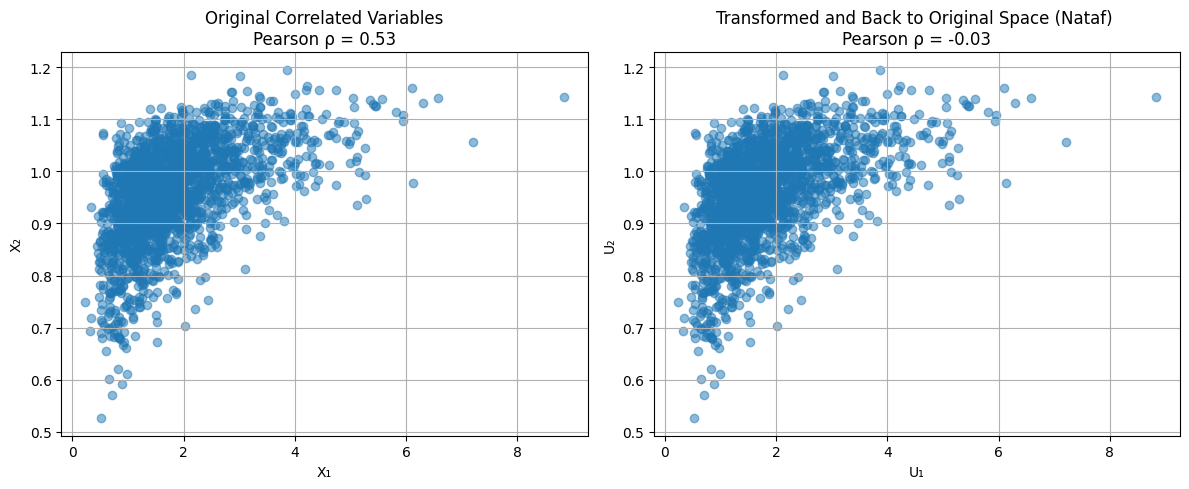

one-to-one correspondance


In [12]:
# =====================================================
# 4. Let see if we can go back. Apply Inverse Nataf Transformation
# =====================================================

U_transformed_nataf = generalized_nataf_transform(X, marginals, corr_matrix)
X_back_to_physical_space = inverse_nataf_transform(U_transformed_nataf, marginals, corr_matrix)

# =====================================================
# Visualize Results
# =====================================================

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original correlated variables
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.5)
ax[0].set_title(f"Original Correlated Variables\nPearson ρ = {np.corrcoef(X.T)[0,1]:.2f}")
ax[0].set_xlabel("X₁")
ax[0].set_ylabel("X₂")
ax[0].grid()
# Transformed variables in standard space
ax[1].scatter(X_back_to_physical_space[:, 0], X_back_to_physical_space[:, 1], alpha=0.5)
ax[1].set_title(f"Transformed and Back to Original Space (Nataf) \nPearson ρ = {np.corrcoef(U_transformed.T)[0,1]:.2f}")
ax[1].set_xlabel("U₁")
ax[1].set_ylabel("U₂")
ax[1].grid()
plt.tight_layout()
plt.show()
print('one-to-one correspondance')